<a href="https://colab.research.google.com/github/Sumedh-Ramteke/Machine-Learning/blob/master/Netflix_Stock_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Netflix Stock Price Prediction System**
Predict the stock price for a date in future based on the historical trends of the Stock Prices

## Import the necessary libraries

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.functions import from_json, col
from pyspark.sql.types import StructType, StructField, StringType, DoubleType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

## Set the input path

In [2]:
input_path = '/content/drive/MyDrive/Colab Notebooks/datasets/streaming/input/NFLX.csv'

## Reading stream for the csv file
Read the csv file to the *inputStream* 

In [3]:
# Import required libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml.regression import LinearRegression

# Create a SparkSession
spark = SparkSession.builder.appName("NetflixStockPrediction").getOrCreate()

# Define the schema for the csv file
schema = "Date DATE, Open FLOAT, High FLOAT, Low FLOAT, Close FLOAT, Volume FLOAT"

# Read the csv file into a streaming DataFrame
streaming_df = spark.readStream.option("header", True)\
            .schema(schema).option('maxFilesPerTrigger', 1)\
            .csv("/content/drive/MyDrive/Colab Notebooks/datasets/streaming/input")

## Preprocessing the dataset 
Preprocessing the dataset and writing to the writeStream for the transformed data

In [4]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

# Define the feature column names
feature_cols = ["Open", "High", "Low", "Close", "Volume"]

# Define the vector assembler transformer
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Define the linear regression model
lr = LinearRegression(featuresCol="features", labelCol="Close", predictionCol="prediction")

# Transform the streaming DataFrame using the vector assembler
transformed_df = assembler.transform(streaming_df)

# Define the streaming query to apply the linear regression model
query = transformed_df \
    .writeStream \
    .format("memory") \
    .queryName("stock_data") \
    .outputMode('update')\
    .start()

## Read the outputStream

In [5]:
df = spark.sql('SELECT * from stock_data')

In [14]:
df.head()

Row(Date=datetime.date(2018, 4, 30), Open=311.07000732421875, High=317.8800048828125, Low=310.1199951171875, Close=312.4599914550781, Volume=312.4599914550781, features=DenseVector([311.07, 317.88, 310.12, 312.46, 312.46]))

## Train-Test Split

In [7]:
training_data = df.select("features", "Close")

In [8]:
train_data, test_data = training_data.randomSplit([0.7, 0.3], seed = 123)

## Train the Linear Regression Model

In [10]:
# Create a LinearRegression model
lr = LinearRegression(featuresCol="features", labelCol="Close", maxIter=10, regParam=0.3, elasticNetParam=0.8)

# Fit the model on the training data
model = lr.fit(train_data)

# Make predictions on the testing data
predictions = model.transform(test_data)

## Evaluate the results to calculate RMSE

In [11]:
# Evaluate the performance of the model using the Root Mean Squared Error (RMSE)
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="Close", metricName="rmse")
rmse = evaluator.evaluate(predictions)

# Print the RMSE of the model
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 1.35584


In [12]:
predictions.columns

['features', 'Close', 'prediction']

## Graph to represent the Actual vs Predicted values

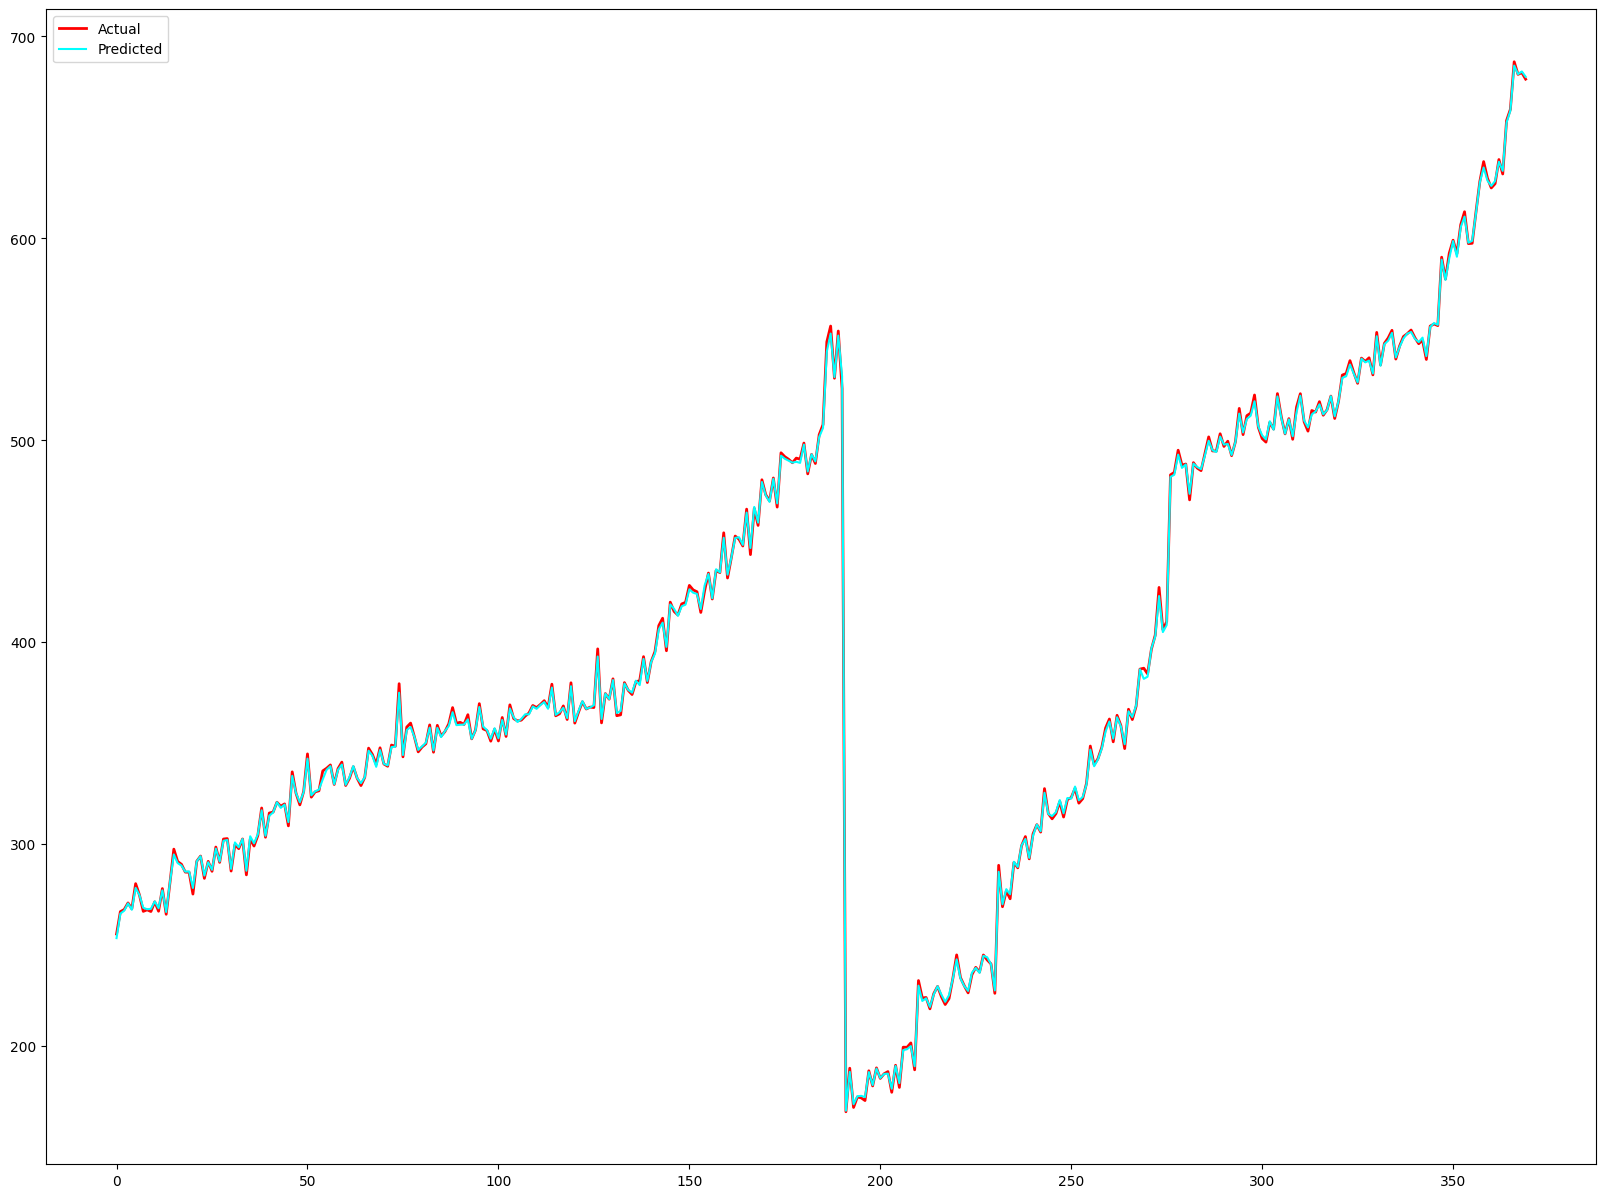

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20, 15))
ax.plot(predictions.select('Close').collect(), color='red', label='Actual')
ax.plot(predictions.select('prediction').collect(), color='cyan', label='Predicted')
ax.lines[0].set_linewidth(2)
ax.legend(loc='upper left')
plt.show()